# Bandit tester

## Preliminaries

In [2]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as student_t
from scipy.stats import cauchy
from scipy.stats import norm
import scipy
from typing import Type, Any

## Starter pack: distributions, basic strategy, bandit tester and comparing function

In [2]:
class Distribution(ABC):
    distributions: list[scipy.stats.rv_continuous]

    def __init__(self, num_distrib, loc_sampler):
        self.num_distrib = num_distrib
        self.loc_sampler = loc_sampler
        self.locations = self.loc_sampler(size=num_distrib)

    @abstractmethod
    def _create_distributions(self):
        pass

    def pull_the_lever(self, pos):
        if self.distributions is None:
            self._create_distributions()
        return self.distributions[pos].rvs()  # Draw a sample from the specified distribution
    

class Gaussian(Distribution):
    def __init__(self, num_distrib, sigma=1, loc_sampler=norm.rvs):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.sigma = sigma  # deviation for gaussian distribution

    def _create_distributions(self):
        self.distributions = [
            norm(scale=self.sigma, loc=loc) for loc in self.locations
        ]


class Student(Distribution):
    def __init__(self, num_distrib, mu, loc_sampler=norm.rvs, need_scale=True):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.need_scale = need_scale
        self.mu = mu  # degrees of freedom for Student's t distribution

    def _create_distributions(self):
        if self.need_scale and self.mu > 2:
            scale = np.sqrt((self.mu - 2) / self.mu)
            self.distributions = [
                student_t(df=self.mu, loc=loc, scale=scale) for loc in self.locations
            ]
        else:
            self.distributions = [
                student_t(df=self.mu, loc=loc) for loc in self.locations
            ]


class Cauchy(Distribution):
    def __init__(self, num_distrib, gamma, loc_sampler=norm.rvs):
        super().__init__(num_distrib, loc_sampler=loc_sampler)
        self.gamma = gamma  # scale parameter for Cauchy distribution

    def _create_distributions(self):
        self.distributions = [
            cauchy(loc=loc, scale=self.gamma) for loc in self.locations
        ]


In [3]:
class Strategy(ABC):
    def __init__(self, num_arms, step_size):
        self.num_arms = num_arms
        self.q_values = np.zeros(num_arms) # Initialize Q-values
        self.counts = np.zeros(num_arms)  # Track visits per arm
        self.step_size = step_size

    @abstractmethod
    def choose_arm(self):
        pass

    @abstractmethod
    def update_q_values(self, arm, reward):
        pass


In [4]:
class BanditTester:
    def __init__(self, distribution: Type[Distribution], strategy: Type[Strategy], distribution_params, strategy_params, num_arms=10, test_num=2000, test_len=1000):
        np.random.seed(42)
        self.distribution = distribution
        self.strategy = strategy
        self.distribution_params = distribution_params
        self.distribution_params["num_distrib"] = num_arms
        self.strategy_params = strategy_params
        self.strategy_params["num_arms"] = num_arms
        self.test_num = test_num
        self.test_len = test_len

    def test(self) -> tuple[np.ndarray, np.ndarray]:
        average_rewards = np.zeros(self.test_len)
        optimal_actions = np.zeros(self.test_len)
        for _ in range(self.test_num):
            strategy = self.strategy(**self.strategy_params)  # Create a new strategy instance for each run
            distribution = self.distribution(**self.distribution_params)  # Create a new distribution instance for each run
            optimal_arm = np.argmax(distribution.locations)  # Determine the optimal arm

            for i in range(self.test_len):
                arm = strategy.choose_arm()
                reward = distribution.pull_the_lever(arm)
                strategy.update_q_values(arm, reward)

                average_rewards[i] += reward / self.test_num
                optimal_actions[i] += int(arm == optimal_arm) / self.test_num

        return average_rewards, optimal_actions



In [5]:
def compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params):

    all_average_rewards, all_optimal_actions = {}, {}

    for distribution, distribution_params, distribution_name in zip(distributions, distributions_params, distributions_names):
        print(distribution_name)
        all_average_rewards[distribution_name], all_optimal_actions[distribution_name] = [], []

        for strategy, strategy_params in zip(strategies, strategies_params):
            bandit_tester = BanditTester(distribution, strategy, distribution_params, strategy_params)
            average_rewards, optimal_actions = bandit_tester.test()
    
            all_average_rewards[distribution_name].append(average_rewards)
            all_optimal_actions[distribution_name].append(optimal_actions)

    return all_average_rewards, all_optimal_actions
        

In [6]:
def plot_strategies_results(average_rewards, optimal_actions, labels, set_ylim=lambda key, i, axes_flat: None):

    # Define x-axis (steps)
    steps = list(range(1, 1001))

    # Create the figure and individual subplots (4 rows, 2 columns)
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))

    # Flatten the 2D array of subplots to iterate over them efficiently
    axes_flat = axes.flatten()

    # Common titles for each plot
    fig.suptitle("Performance of Strategies", fontsize=16)
    for ax in axes_flat:
        ax.set_xlabel("Steps")

    # Loop through each key (distribution)
    for i, key in enumerate(average_rewards.keys()):
        # Set titles for the first column (average reward)
        axes_flat[2 * i].set_title(f"{key} - Average Reward")
        # Set titles for the second column (optimal action)
        axes_flat[2 * i + 1].set_title(f"{key} - % Optimal Action")

        # Plot average reward for each epsilon value
        for j, epsilon_label, data in zip(range(len(labels)), labels, average_rewards[key]):
            axes_flat[2 * i].plot(steps, data, label=epsilon_label)
        axes_flat[2 * i].set_ylabel("Average reward")
        axes_flat[2 * i].legend()

        # Plot optimal actions (convert to percentages) for each epsilon value
        for j, epsilon_label, data in zip(range(len(labels)), labels, optimal_actions[key]):
            axes_flat[2 * i + 1].plot(steps, [100 * x for x in data], label=epsilon_label)
        axes_flat[2 * i + 1].set_ylabel("% Optimal action")
        axes_flat[2 * i + 1].legend()

        set_ylim(key, i, axes_flat)
        

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [7]:
def plot_same_strategies_for_optimal_actions(average_rewards, optimal_actions, labels, set_ylim=lambda label, i, axes_flat: None):
    # Define x-axis (steps)
    steps = list(range(1, 1001))

    # Create the figure and individual subplots (4 rows, 2 columns)
    fig, axes = plt.subplots(len(labels), 2, figsize=(15, 4 * len(labels)))

    # Flatten the 2D array of subplots to iterate over them efficiently
    axes_flat = axes.flatten()

    # Common titles for each plot
    fig.suptitle("Performance of Strategies", fontsize=16)
    for ax in axes_flat:
        ax.set_xlabel("Steps")

    for i, label in enumerate(labels):
        axes_flat[2 * i].set_title(f"{label} - Average Reward")
        axes_flat[2 * i + 1].set_title(f"{label} - % Optimal Action")

        for key in optimal_actions.keys():
            if key != "Standard Cauchy":
                axes_flat[2 * i].plot(steps, average_rewards[key][i], label=key)
            axes_flat[2 * i + 1].plot(steps, [100 * x for x in optimal_actions[key][i]], label=key)
            
        axes_flat[2 * i].set_ylabel("Average reward")
        axes_flat[2 * i + 1].set_ylabel("% Optimal action")

        axes_flat[2 * i].legend()
        axes_flat[2 * i + 1].legend()

        set_ylim(label, i, axes_flat)
        

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

## Comparing greedy and $\epsilon$-greedy strategies

In [8]:
class EpsilonGreedy(Strategy):
    def __init__(self, num_arms, epsilon=0.1, step_size=lambda count: 1 / count):
        super().__init__(num_arms, step_size=step_size)
        self.epsilon = epsilon

    def choose_arm(self):
        if np.random.random() < self.epsilon:
            # Explore: choose random arm
            return np.random.randint(0, self.num_arms)
        else:
            # Exploit: choose arm with highest estimated reward
            return np.argmax(self.q_values)

    def update_q_values(self, arm, reward):
        self.counts[arm] += 1
        self.q_values[arm] = self.q_values[arm] + self.step_size(self.counts[arm]) * (reward - self.q_values[arm])


class Greedy(EpsilonGreedy):
    def __init__(self, num_arms, step_size=lambda count: 1 / count):
        super().__init__(num_arms, epsilon=0, step_size=step_size)


In [9]:
distributions = [Gaussian, Student, Student, Cauchy]
distributions_params = [{'sigma': 1}, {'mu': 3}, {'mu': 2}, {'gamma': 1}]
distributions_names = ["Standard Normal", "Student with "+r"$\nu=3$", "Student with "+r"$\nu=2$", "Standard Cauchy"]

In [55]:
strategies = [Greedy, EpsilonGreedy, EpsilonGreedy]
strategies_params = [{}, {'epsilon': 0.01}, {'epsilon': 0.1}]

In [56]:
average_rewards, optimal_actions = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal
Student with $\nu=3$
Student with $\nu=2$
Standard Cauchy


In [57]:
labels = [r"$\epsilon = 0$ (greedy)", r"$\epsilon = 0.01$", r"$\epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(0.4, None)  # Set lowest y-axis value to 0.4
    axes_flat[2 * i + 1].set_ylim(15, 90)  # Set y-axis limits for optimal action to [15, 90]

    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        axes_flat[2 * i + 1].set_ylim(15, 40)  # Set x-axis limits for optimal action

def set_label_ylim(label: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(0.6, 1.6)

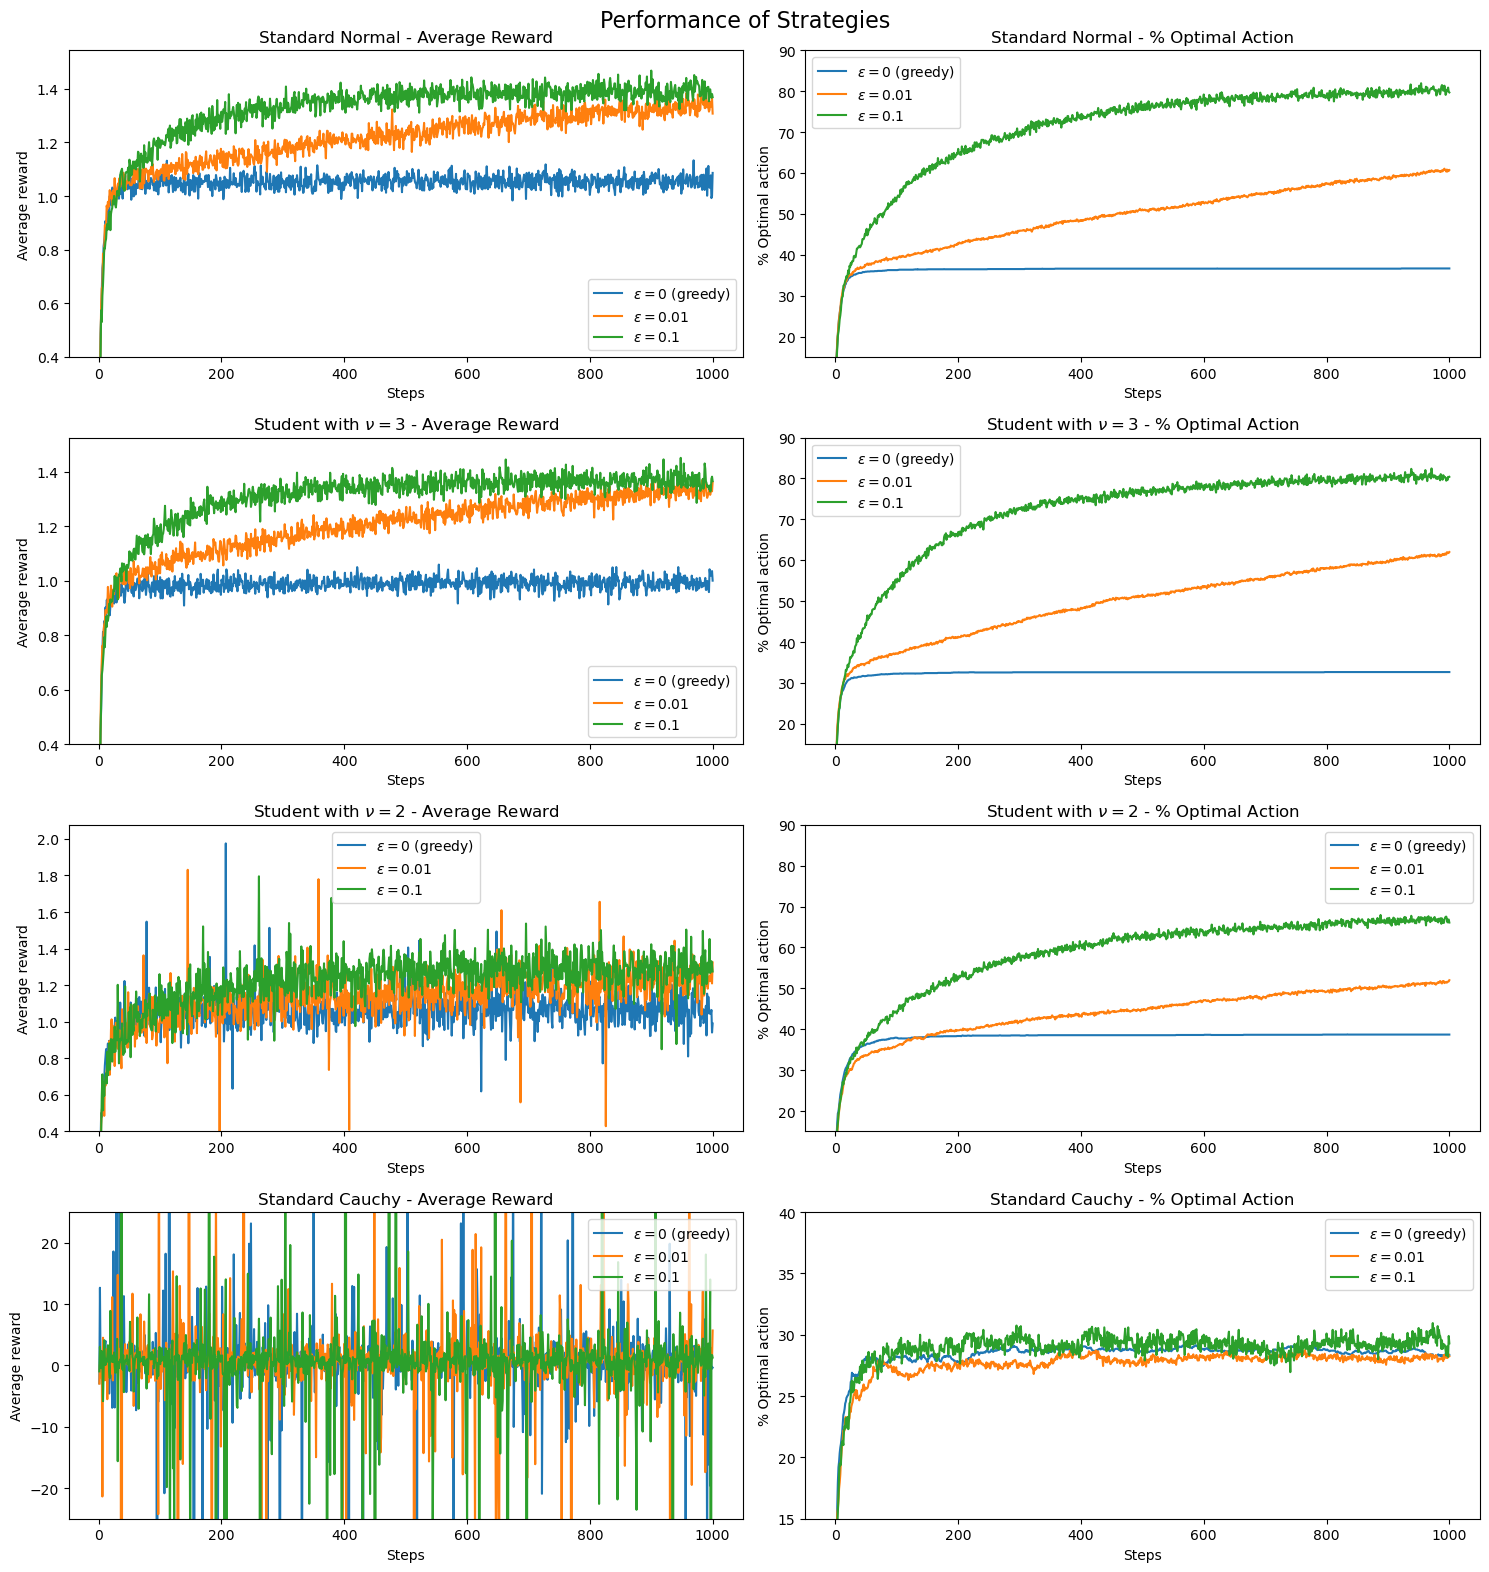

In [58]:
plot_strategies_results(average_rewards, optimal_actions, labels, set_ylim)

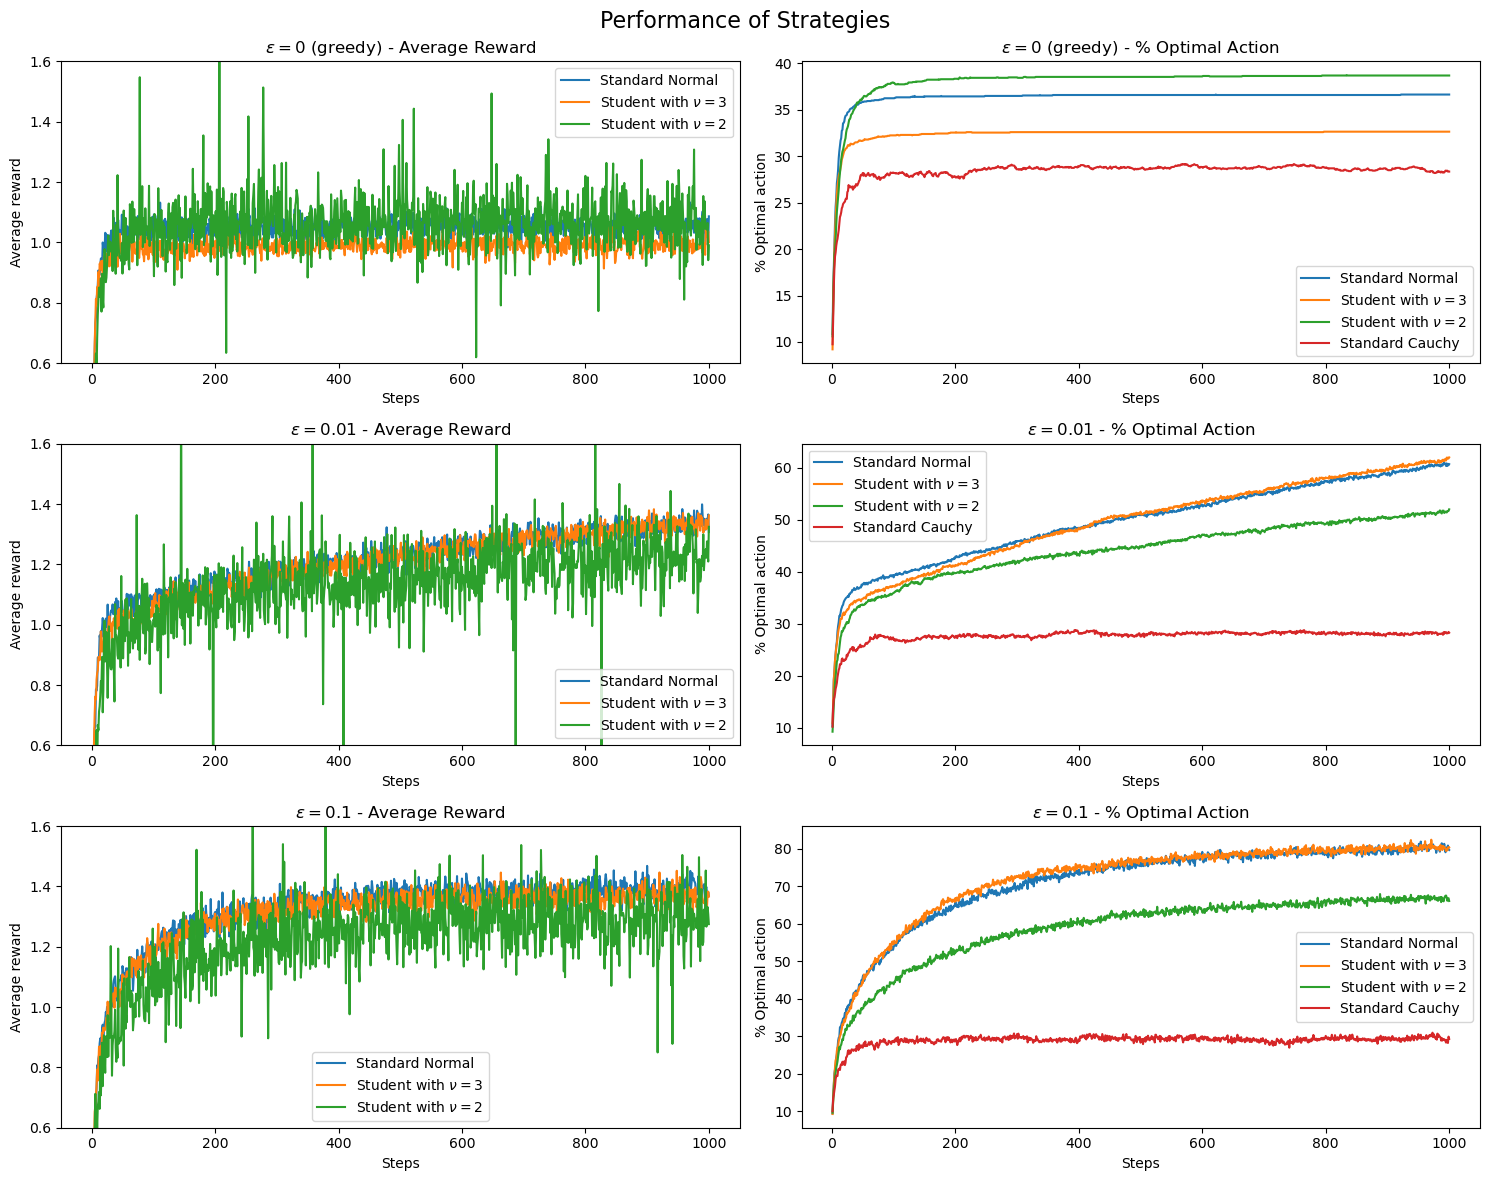

In [59]:
plot_same_strategies_for_optimal_actions(average_rewards, optimal_actions, labels, set_ylim=set_label_ylim)

## Positive initialization

In [10]:
class PositiveQ(EpsilonGreedy):
    def __init__(self, num_arms, epsilon=0, step_size=lambda _: 0.1, pos_q=5):
        super().__init__(num_arms, epsilon=epsilon, step_size=step_size)
        self.q_values = np.ones(num_arms) * pos_q  # Initialize Q-values with positive values


In [42]:
strategies = [PositiveQ, PositiveQ, EpsilonGreedy]
strategies_params = [{'epsilon': 0}, {'epsilon': 0.1}, {'epsilon': 0.1, 'step_size': lambda _: 0.1}]

In [43]:
average_rewards, optimal_actions = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal
Student with $\nu=3$
Student with $\nu=2$
Standard Cauchy


In [44]:
labels = ["Optimistic, greedy"+"\n"+r"$Q_1=5, \epsilon = 0$",
          r"Optimistic, $\epsilon$-greedy"+"\n"+r"$Q_1=5, \epsilon = 0.1$",
          r"Realistic, $\epsilon$-greedy"+"\n"+r"$Q_1=0, \epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(0.2, None)  # Set lowest y-axis value to 0.2

    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward
        axes_flat[2 * i + 1].set_ylim(None, 35)  # Set x-axis limits for optimal action

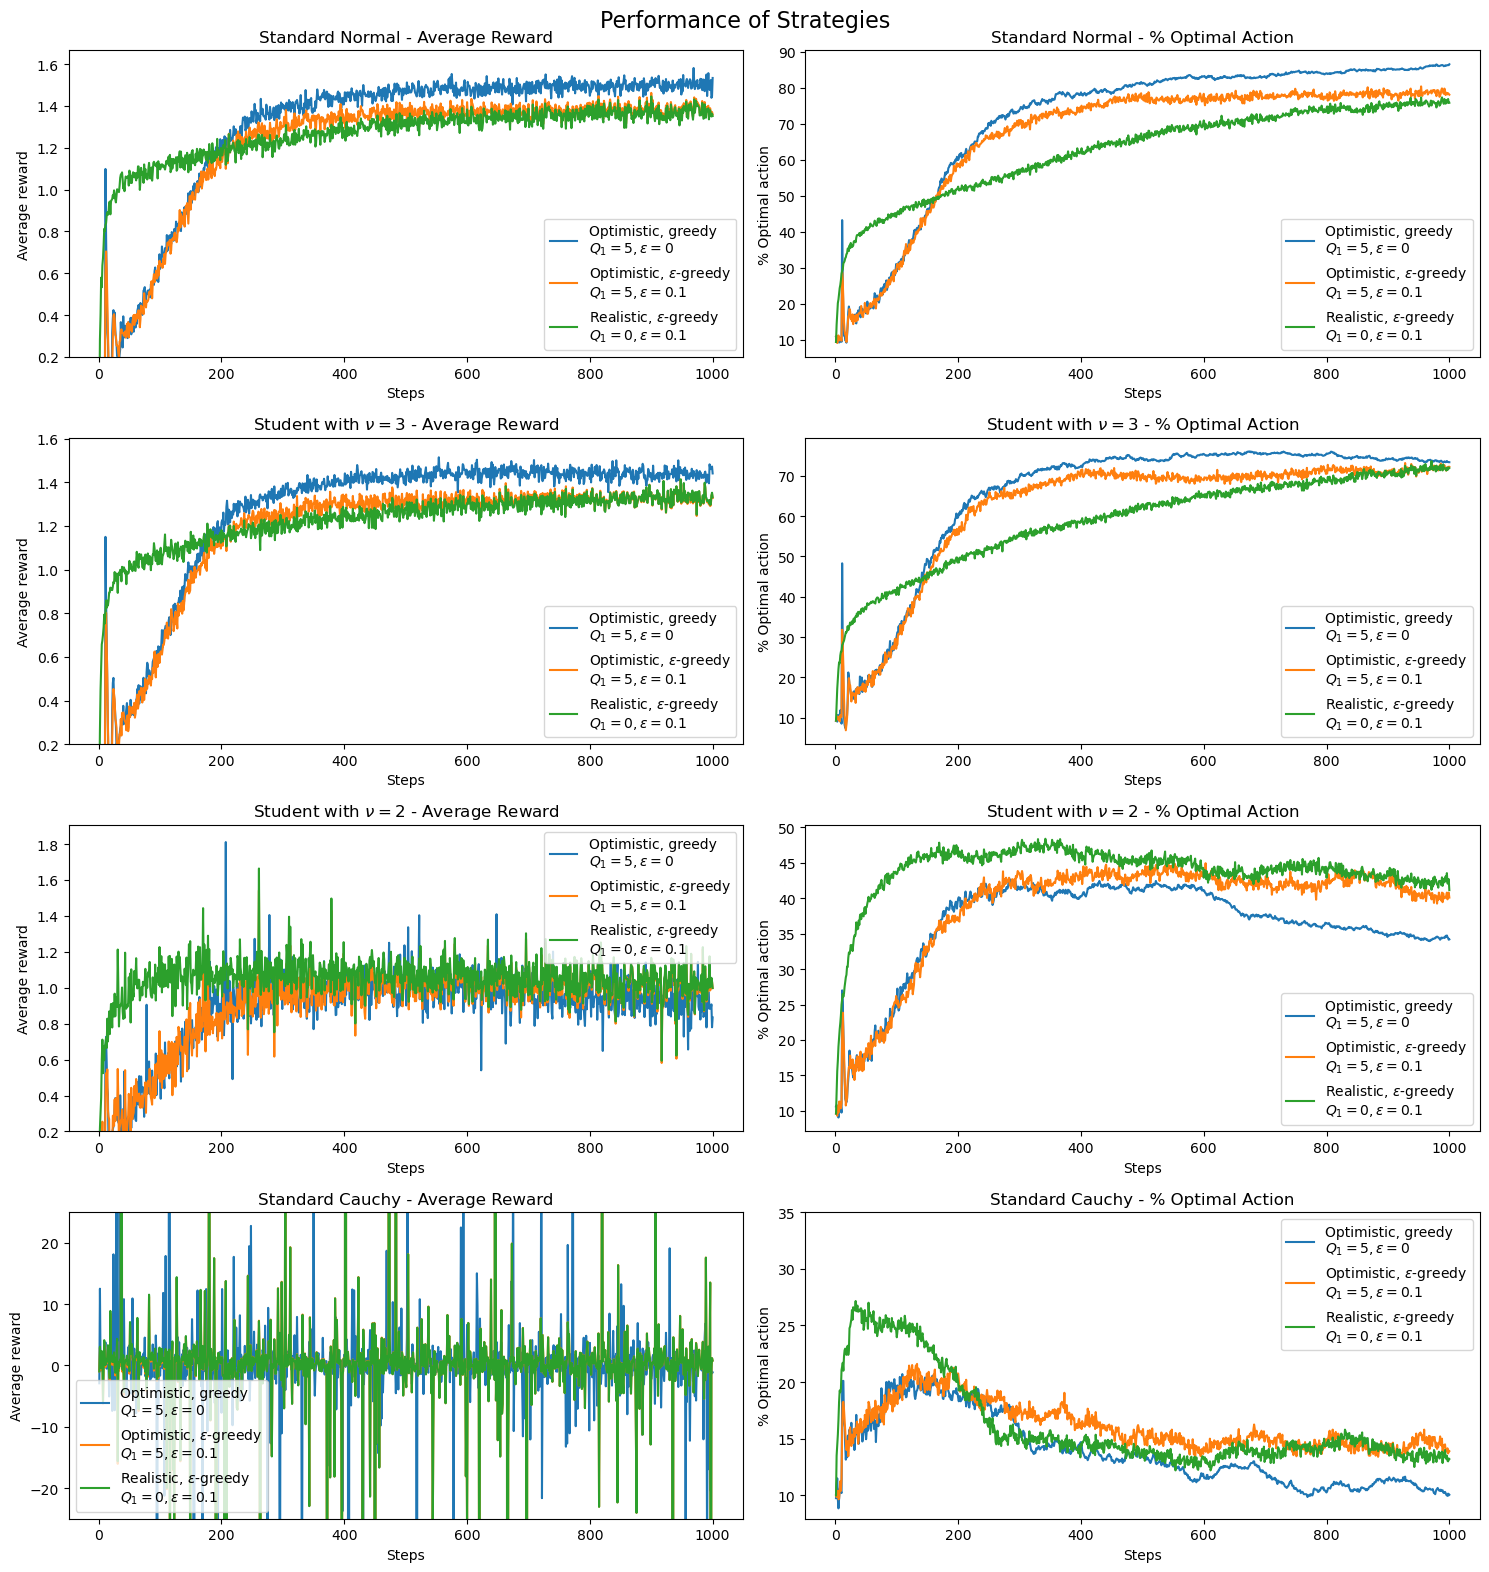

In [45]:
plot_strategies_results(average_rewards, optimal_actions, labels, set_ylim)

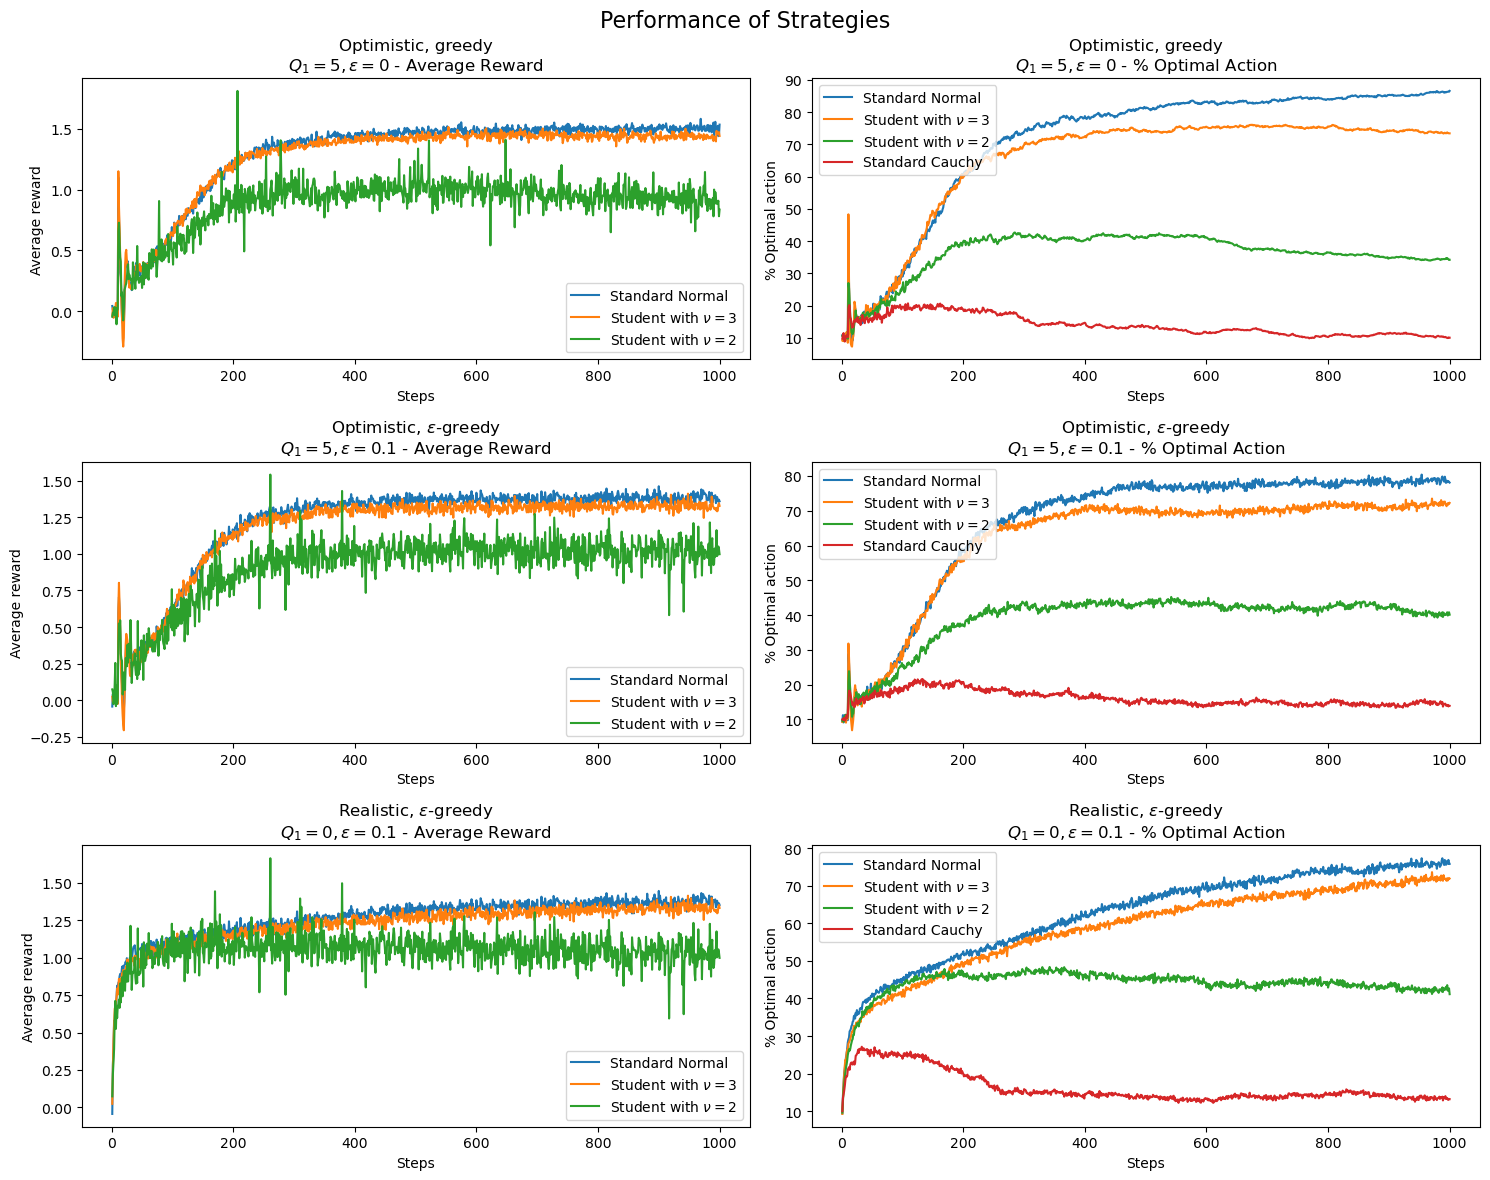

In [52]:
plot_same_strategies_for_optimal_actions(average_rewards, optimal_actions, labels)

## Upper-Confidence-Bound Action Selection

In [11]:
class UCB(Strategy):
    def __init__(self, num_arms, c=2, step_size=lambda x: 1 / x):
        super().__init__(num_arms, step_size=step_size)
        self.c = c  # Exploration parameter
        self.t = 0 # time

    def choose_arm(self):
        self.t += 1  # Track total number of steps taken
        # Avoid division by zero by adding a small constant to the denominator
        safe_counts = np.maximum(self.counts, 0.001)  # Ensure no element is zero
        upper_bounds = self.q_values + self.c * np.sqrt(np.log(self.t) / safe_counts)
        return np.argmax(upper_bounds)  # Choose arm with highest upper bound
    
    def update_q_values(self, arm, reward):
        self.counts[arm] += 1
        self.q_values[arm] = self.q_values[arm] + self.step_size(self.counts[arm]) * (reward - self.q_values[arm])

In [61]:
strategies = [UCB, EpsilonGreedy]
strategies_params = [{'c': 2}, {'epsilon': 0.1}]

In [62]:
average_rewards, optimal_actions = compare_strategies(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal
Student with $\nu=3$
Student with $\nu=2$
Standard Cauchy


In [70]:
labels = [r"UCB $c=2$", r"$\epsilon$-greedy, $\epsilon = 0.1$"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward

def set_label_ylim(key: str, i: int, axes_flat) -> None:
    axes_flat[2 * i].set_ylim(0.5, 1.75)

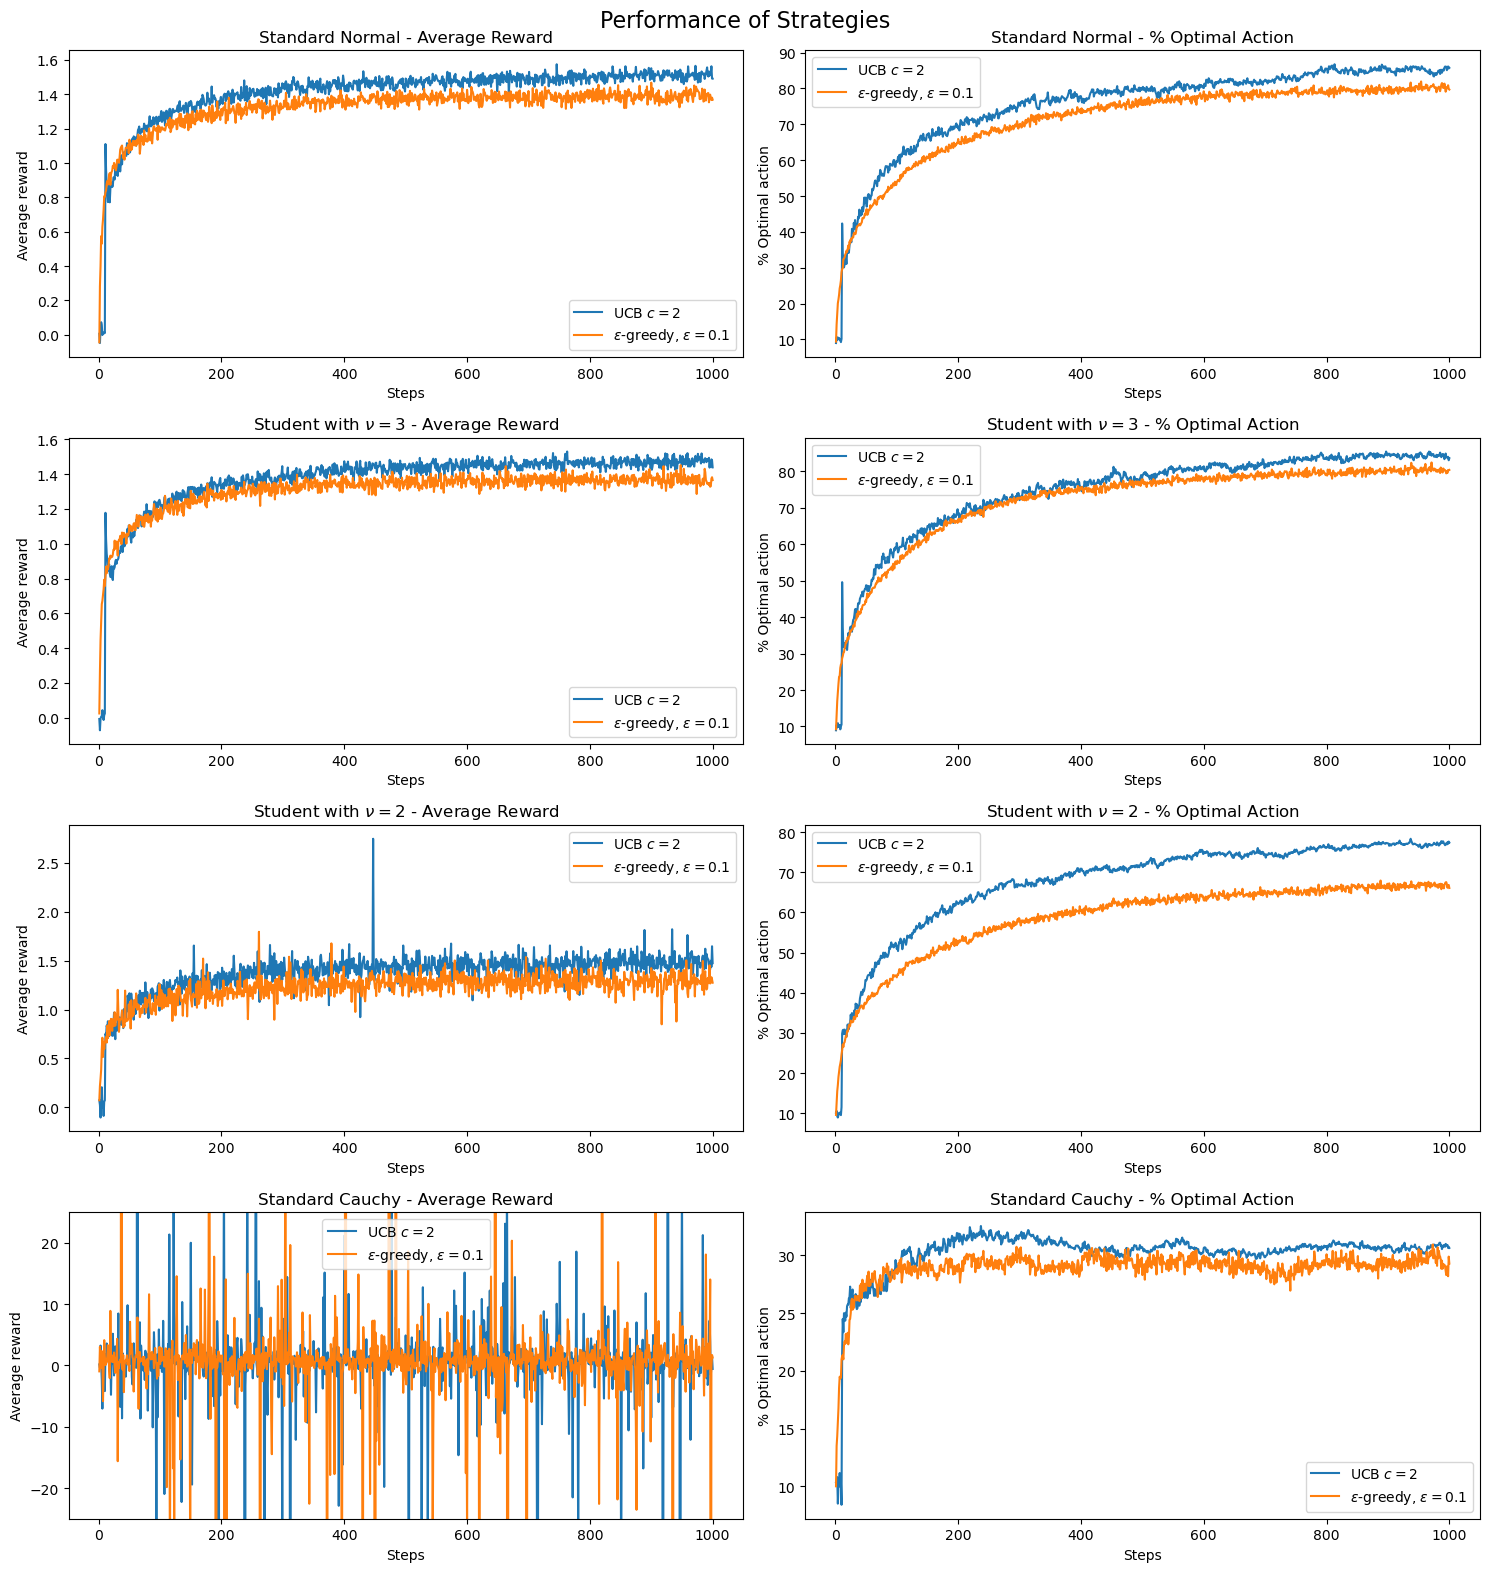

In [64]:
plot_strategies_results(average_rewards, optimal_actions, labels, set_ylim)

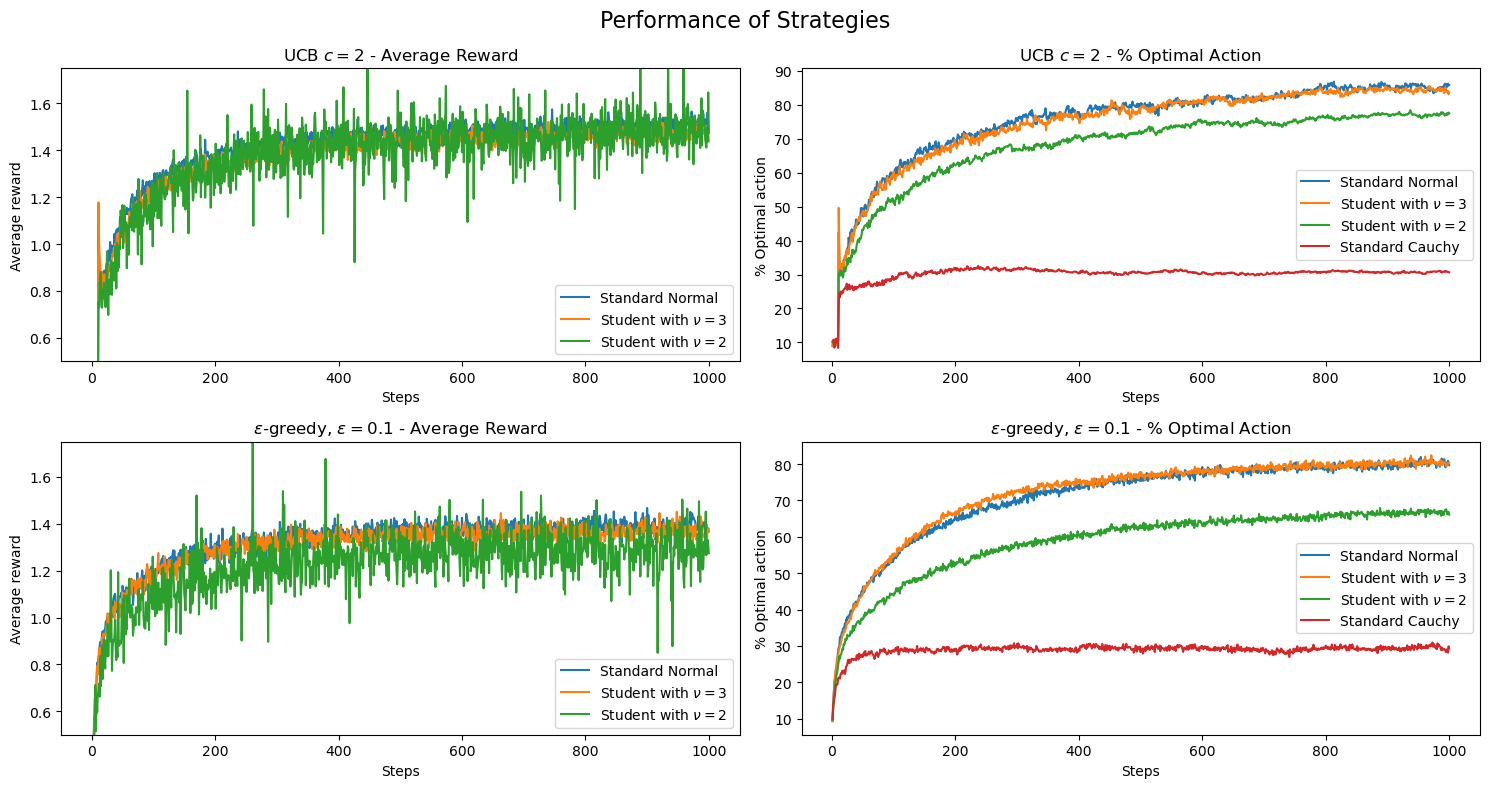

In [72]:
plot_same_strategies_for_optimal_actions(average_rewards, optimal_actions, labels, set_ylim=set_label_ylim)

## Gradient bandits

In [12]:
class GradientBandit(Strategy):
    def __init__(self, num_arms, baseline=True, alpha=0.1, step_size=lambda x: 1 / x):
        super().__init__(num_arms, step_size=step_size)
        self.h_values = np.zeros(self.num_arms)
        self.probs = np.zeros(self.num_arms)
        self.alpha = alpha
        self.has_baseline = baseline
        self.baseline = 0
        self.t = 0

    def choose_arm(self):
        self.probs = np.exp(self.h_values) / np.sum(np.exp(self.h_values))
        return np.random.choice(self.num_arms, p=self.probs)

    def update_q_values(self, arm, reward):
        self.counts[arm] += 1
        self.t += 1

        delta_reward = reward - self.baseline
        self.h_values -= self.alpha * delta_reward * self.probs
        self.h_values[arm] += self.alpha * delta_reward
        self.h_values -= np.max(self.h_values)

        self.baseline += (self.step_size(self.t) * delta_reward) if self.has_baseline else 0


In [74]:
loc_sampler = lambda size: norm.rvs(size=size) + 4
biased_distributions_params = [{'sigma': 1, 'loc_sampler': loc_sampler},
                        {'mu': 3, 'loc_sampler': loc_sampler},
                        {'mu': 2, 'loc_sampler': loc_sampler},
                        {'gamma': 1, 'loc_sampler': loc_sampler}]

In [75]:
strategies = [GradientBandit, GradientBandit, GradientBandit, GradientBandit]
strategies_params = [{'baseline': True, 'alpha': 0.1},
                     {'baseline': True, 'alpha': 0.4},
                     {'baseline': False, 'alpha': 0.1},
                     {'baseline': False, 'alpha': 0.4}]

In [76]:
average_rewards, optimal_actions = compare_strategies(distributions, biased_distributions_params, distributions_names, strategies, strategies_params)

Standard Normal
Student with $\nu=3$
Student with $\nu=2$
Standard Cauchy


In [77]:
labels = [r"$\alpha=0.1$, with baseline",
          r"$\alpha=0.4$, with baseline",
          r"$\alpha=0.1$, without baseline",
          r"$\alpha=0.4$, without baseline"]

def set_ylim(key: str, i: int, axes_flat) -> None:
    # Special adjustments for the last row (Standard Cauchy)
    if key == "Standard Cauchy":
        axes_flat[2 * i].set_ylim(-25, 25)  # Set x-axis limits for average reward

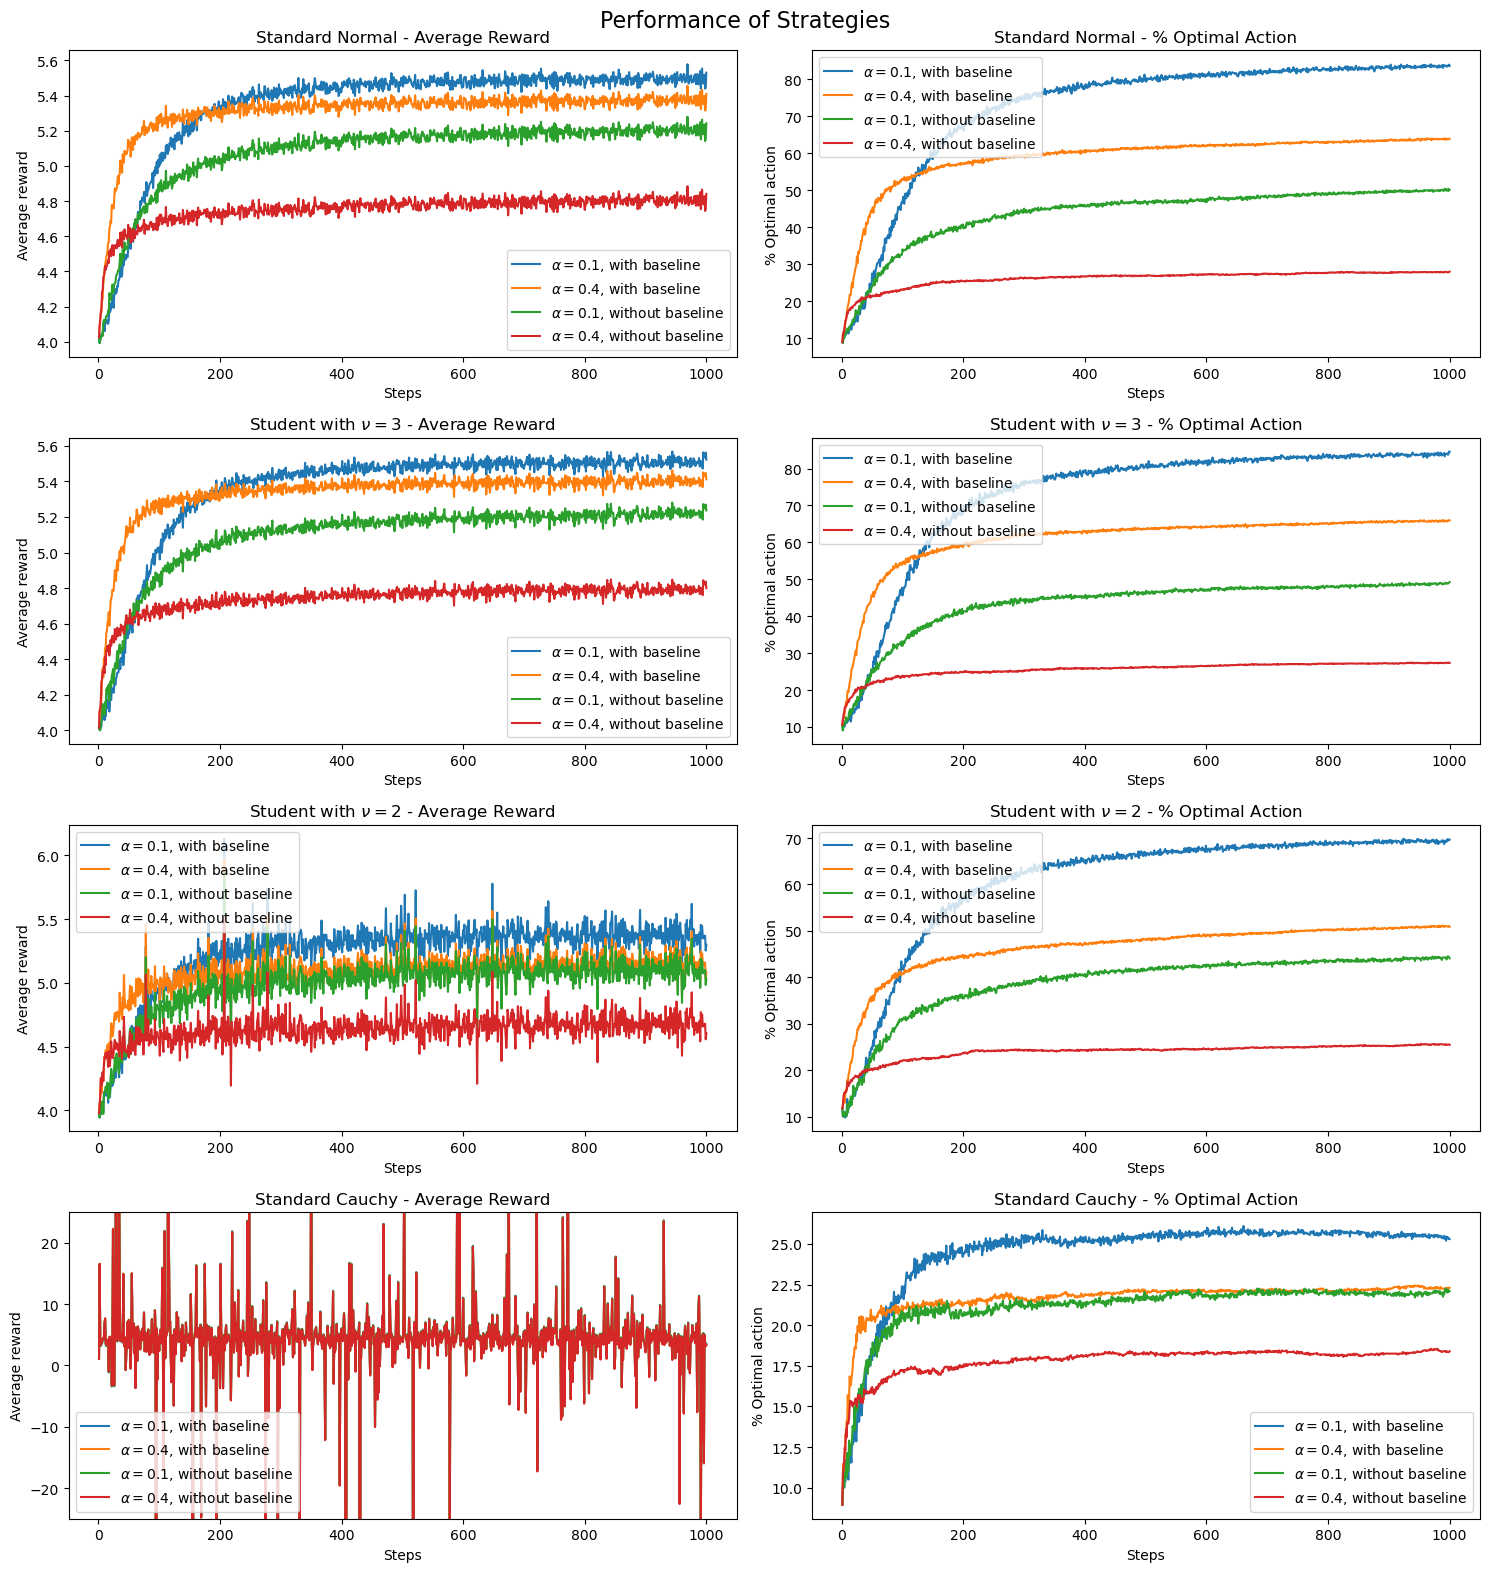

In [78]:
plot_strategies_results(average_rewards, optimal_actions, labels, set_ylim)

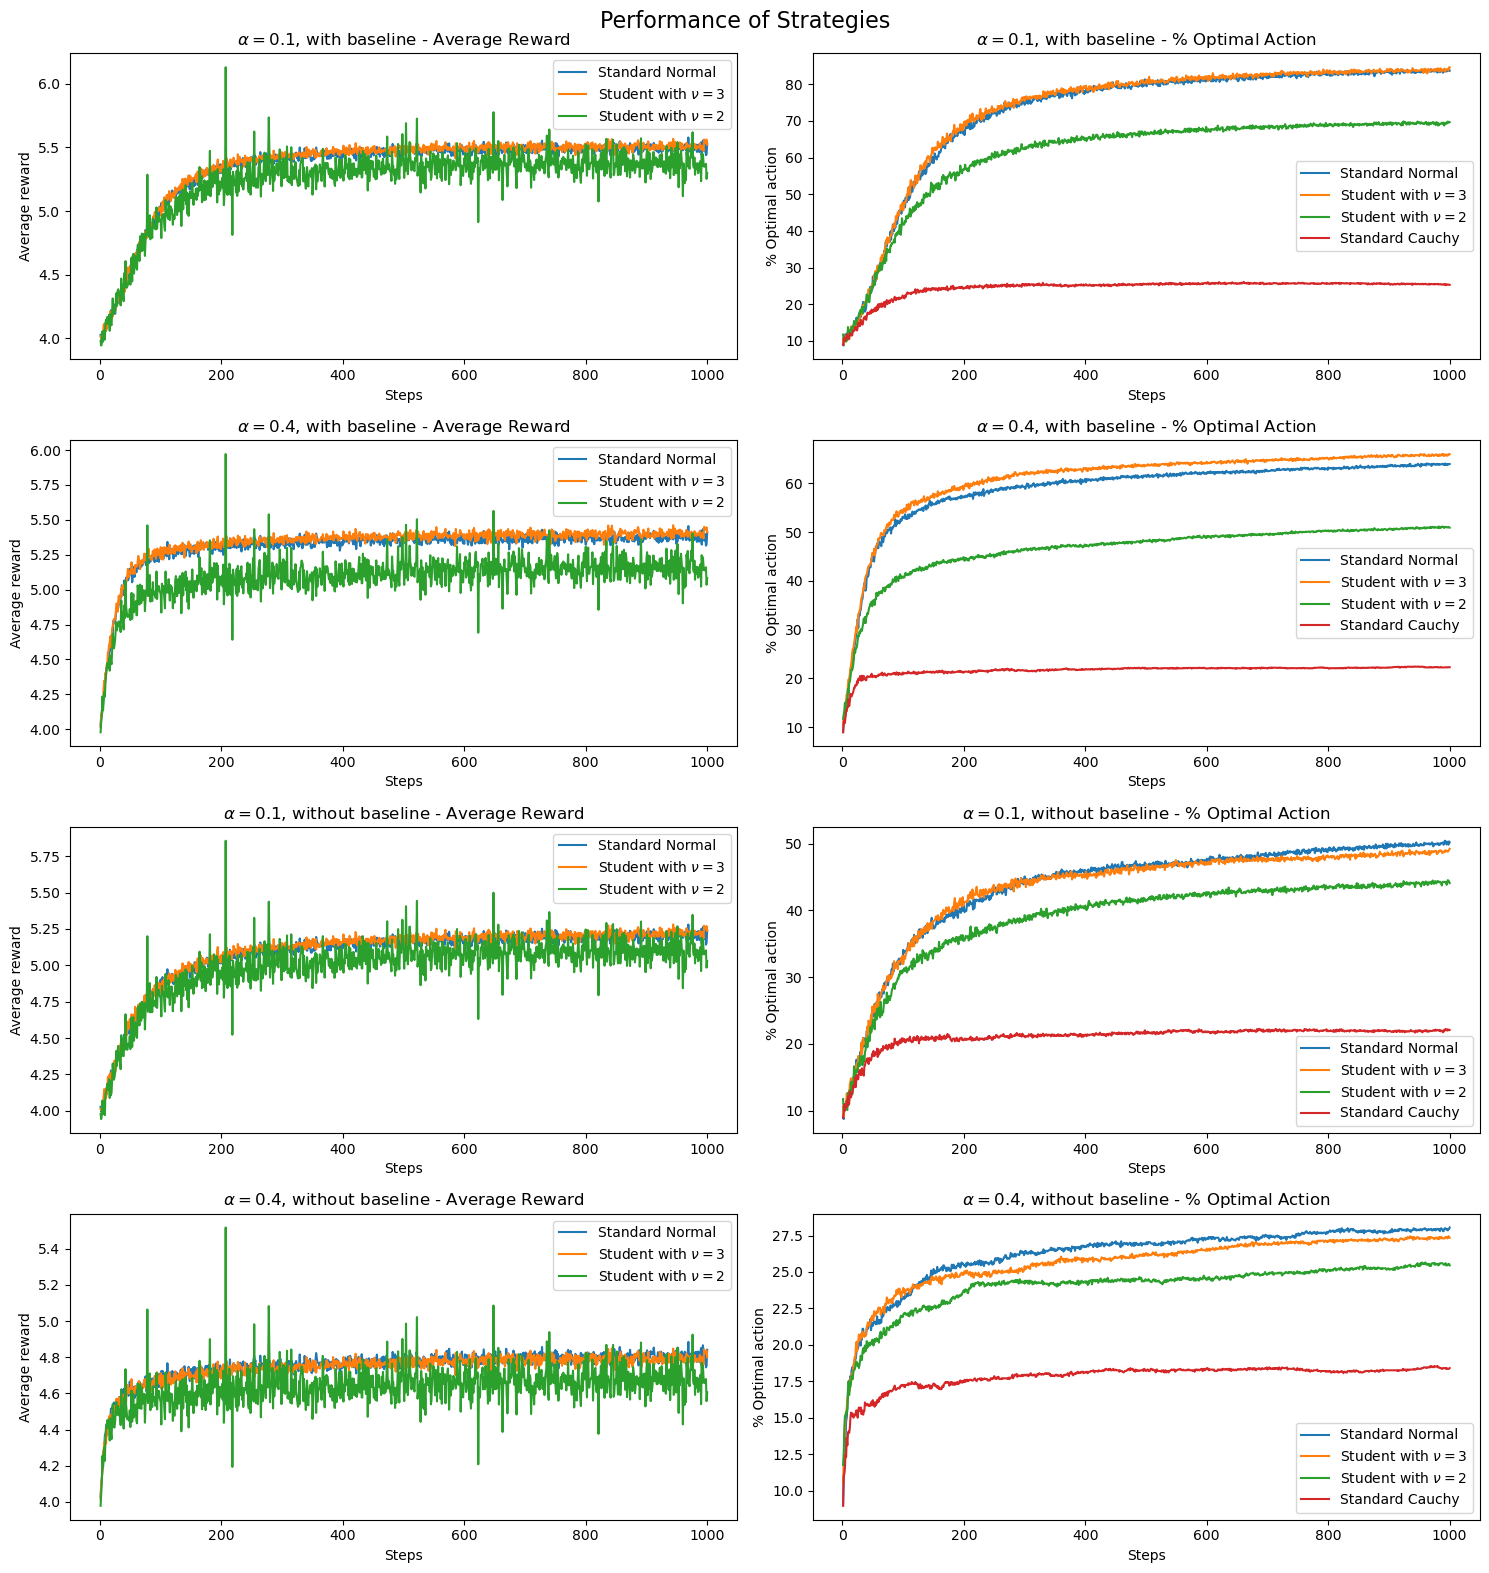

In [79]:
plot_same_strategies_for_optimal_actions(average_rewards, optimal_actions, labels)

## Overall comparison

In [13]:
strategies = [EpsilonGreedy, PositiveQ, UCB, GradientBandit]
strategies_params = {EpsilonGreedy.__name__: [{'epsilon': 1 / 128}, {'epsilon': 1 / 64}, {'epsilon': 1 / 32}, {'epsilon': 1 / 16}, {'epsilon': 1 / 8}, {'epsilon': 1 / 4}, {'epsilon': 1 / 2}, {'epsilon': 1}, {'epsilon': 2}, {'epsilon': 4}],
                     PositiveQ.__name__: [{'pos_q': 1 / 128}, {'pos_q': 1 / 64}, {'pos_q': 1 / 32}, {'pos_q': 1 / 16}, {'pos_q': 1 / 8}, {'pos_q': 1 / 4}, {'pos_q': 1 / 2}, {'pos_q': 1}, {'pos_q': 2}, {'pos_q': 4}],
                     UCB.__name__: [{'c': 1 / 128}, {'c': 1 / 64}, {'c': 1 / 32}, {'c': 1 / 16}, {'c': 1 / 8}, {'c': 1 / 4}, {'c': 1 / 2}, {'c': 1}, {'c': 2}, {'c': 4}],
                     GradientBandit.__name__: [{'alpha': 1 / 128}, {'alpha': 1 / 64}, {'alpha': 1 / 32}, {'alpha': 1 / 16}, {'alpha': 1 / 8}, {'alpha': 1 / 4}, {'alpha': 1 / 2}, {'alpha': 1}, {'alpha': 2}, {'alpha': 4}]}

In [14]:
def compare_overall(distributions: list[Type[Distribution]],
                    distributions_params: list[dict],
                    distributions_names: list[str],
                    strategies: list[Type[Strategy]],
                    strategies_params: dict[str, list[dict[str, float]]]) -> tuple[dict, dict]:

    param_average_rewards, param_optimal_actions = {}, {}

    for distribution, distribution_params, distribution_name in zip(distributions, distributions_params, distributions_names):
        print(distribution_name)
        param_average_rewards[distribution_name], param_optimal_actions[distribution_name] = {}, {}

        for strategy in strategies:
            param_average_rewards[distribution_name][strategy.__name__] = []
            param_optimal_actions[distribution_name][strategy.__name__] = []
            strategy_params = strategies_params[strategy.__name__]
            for one_param in strategy_params:
                bandit_tester = BanditTester(distribution, strategy, distribution_params, strategy_params=one_param, test_num=1000)
                average_rewards, optimal_actions = bandit_tester.test()
        
                param_average_rewards[distribution_name][strategy.__name__].append(average_rewards[-1])
                param_optimal_actions[distribution_name][strategy.__name__].append(np.max(optimal_actions))

    return param_average_rewards, param_optimal_actions

In [15]:
average_rewards, optimal_actions = compare_overall(distributions, distributions_params, distributions_names, strategies, strategies_params)

Standard Normal
Student with $\nu=3$
Student with $\nu=2$
Standard Cauchy


In [19]:
param_values = {key: [list(val_inner.values())[0] for val_inner in val_outer] for key, val_outer in strategies_params.items()}

In [20]:
x_ticks_labels = ['1 / 128', '1 / 64', '1 / 32', '1 / 16', '1 / 8', '1 / 4', '1 / 2', '1', '2', '4']
x_ticks = [1 / 128, 1 / 64, 1 / 32, 1 / 16, 1 / 8, 1 / 4, 1 / 2, 1, 2, 4]

In [21]:
labels = {'EpsilonGreedy': r"$\epsilon$-greedy",
          'PositiveQ': r"greedy with optimistic init, $\alpha=0.1$",
          'UCB': "UCB",
          'GradientBandit': "gradient bandit"}

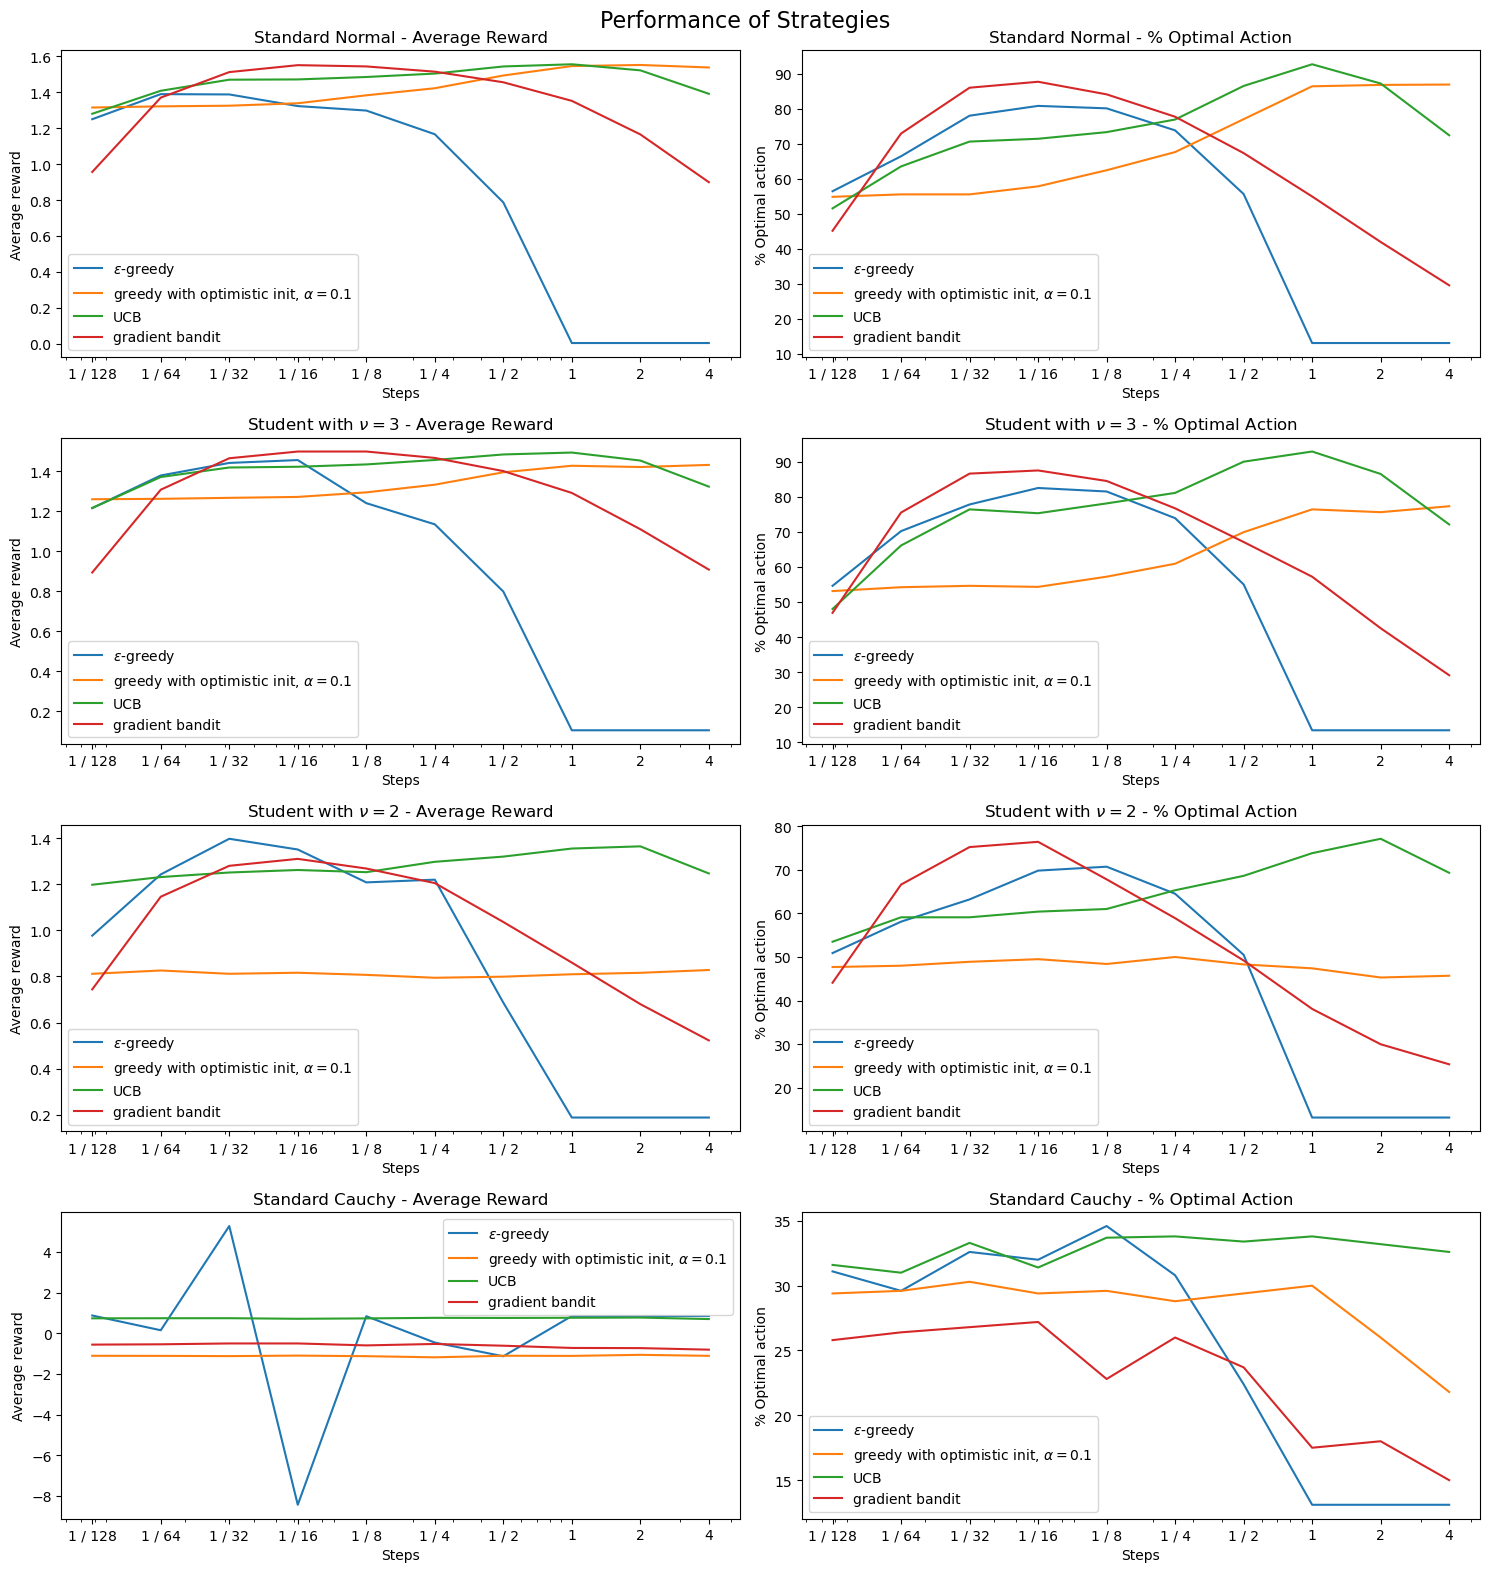

In [22]:
# Define x-axis (steps)

# Create the figure and individual subplots (4 rows, 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(15, 16))

# Flatten the 2D array of subplots to iterate over them efficiently
axes_flat = axes.flatten()

# Common titles for each plot
fig.suptitle("Performance of Strategies", fontsize=16)
for ax in axes_flat:
    ax.set_xlabel("Steps")

# Loop through each key (distribution)
for i, key in enumerate(average_rewards.keys()):
    # Set titles for the first column (average reward)
    axes_flat[2 * i].set_title(f"{key} - Average Reward")
    # Set titles for the second column (optimal action)
    axes_flat[2 * i + 1].set_title(f"{key} - % Optimal Action")

    # Plot average reward for each epsilon value
    for strategy in labels.keys():
        axes_flat[2 * i].plot(param_values[strategy], average_rewards[key][strategy], label=labels[strategy])
    axes_flat[2 * i].set_ylabel("Average reward")
    axes_flat[2 * i].set_xscale('log')
    axes_flat[2 * i].set_xticks(x_ticks, x_ticks_labels)
    axes_flat[2 * i].legend()

    # Plot optimal actions (convert to percentages) for each epsilon value
    for strategy in labels.keys():
        axes_flat[2 * i + 1].plot(param_values[strategy], [100 * x for x in optimal_actions[key][strategy]], label=labels[strategy])
    axes_flat[2 * i + 1].set_ylabel("% Optimal action")
    axes_flat[2 * i + 1].set_xscale('log')
    axes_flat[2 * i + 1].set_xticks(x_ticks, x_ticks_labels)
    axes_flat[2 * i + 1].legend()

    # set_ylim(key, i, axes_flat)
    

# Adjust layout and display the plots
plt.tight_layout()
plt.show()